In [1]:
# Basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Model library
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_absolute_error

# Model saving
import joblib

# Remove warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
outlier = []
no_outlier = []
def plot_dist(df, col):
    fig, axs = plt.subplots(ncols = 2, nrows = 1,figsize = (8, 2))

    # Plot Histogram
    sns.histplot(df[col], ax = axs[0], bins=30)
    axs[0].set_title(f"Histogram {col}")
    axs[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axs[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axs[0].legend()

    # Plot Boxplot
    sns.boxplot(y=df[col], ax =  axs[1])
    axs[1].set_title(f"Boxplot {col}")

    plt.show()

    # Print Skewness
    print('Skewness :', df[col].skew())
    if -0.1 <= df[col].skew() <= 0.1:
        print("Column |{}| normal distribution".format(col))
    elif df[col].skew() > 0.1:
        print("Column |{}| right skewed".format(col))
    elif df[col].skew() < -0.1:
        print("Column |{}| left skewed".format(col))

    # Outlier Detection using IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].tolist()

    if outliers:
        print(f"⚠️ Outliers detected in '{col}': {outliers[:5]}")
        outlier.append(col)
    else:
        print(f"✅ No outliers detected in '{col}'.")
        no_outlier.append(col)
    print("========================================================================================")

In [3]:
df = pd.read_csv('StudentPerformanceFactors.csv')

display(df.head())
print(f'Rows : {df.shape[0]} x Cols : {df.shape[1]}')

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


Rows : 6607 x Cols : 20


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [5]:
df[df.duplicated()].any()

Hours_Studied                 False
Attendance                    False
Parental_Involvement          False
Access_to_Resources           False
Extracurricular_Activities    False
Sleep_Hours                   False
Previous_Scores               False
Motivation_Level              False
Internet_Access               False
Tutoring_Sessions             False
Family_Income                 False
Teacher_Quality               False
School_Type                   False
Peer_Influence                False
Physical_Activity             False
Learning_Disabilities         False
Parental_Education_Level      False
Distance_from_Home            False
Gender                        False
Exam_Score                    False
dtype: bool

# Data Splitting

In [6]:
X = df.drop(['Exam_Score'], axis = 1)
y = df['Exam_Score']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Train-set Dimension: ', X_train.shape)
print('Test-set Dimension: ', X_test.shape)

Train-set Dimension:  (5285, 19)
Test-set Dimension:  (1322, 19)


# Data Visualization

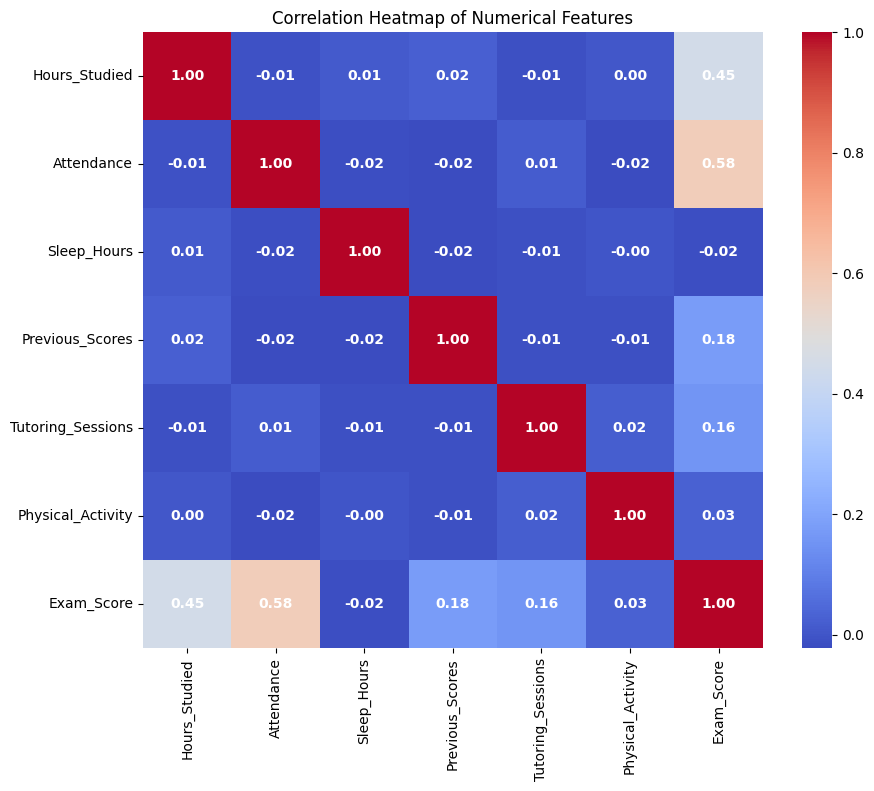

In [8]:
numeric_df = df.select_dtypes(include = 'number')
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot = True,
            cmap='coolwarm',
            fmt = '.2f',
            annot_kws = {'size': 10, 'weight':'bold', 'color':'white'})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

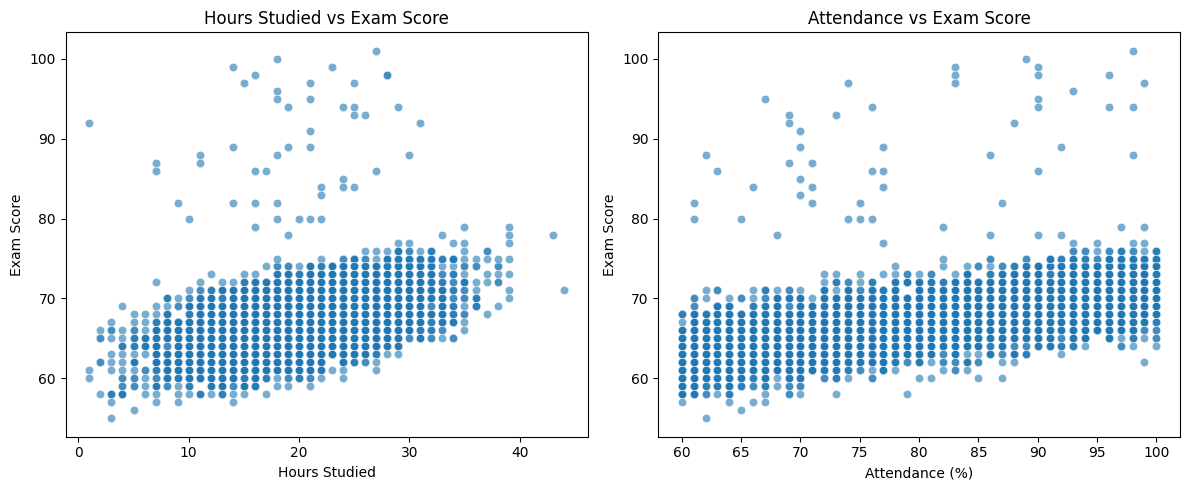

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=df["Hours_Studied"], y=df["Exam_Score"], alpha=0.6)
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Hours Studied vs Exam Score")

plt.subplot(1, 2, 2)
sns.scatterplot(x=df["Attendance"], y=df["Exam_Score"], alpha=0.6)
plt.xlabel("Attendance (%)")
plt.ylabel("Exam Score")
plt.title("Attendance vs Exam Score")

plt.tight_layout()
plt.show()


In [10]:
num_cols = X_train.select_dtypes(include = ['float64', 'int64']).columns.to_list()
object_cols = X_train.select_dtypes(include = 'object').columns.to_list()

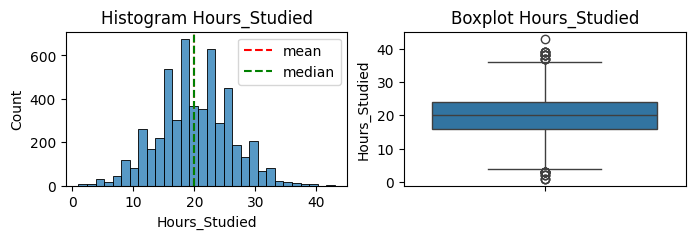

Skewness : -0.00038292363310139045
Column |Hours_Studied| normal distribution
⚠️ Outliers detected in 'Hours_Studied': [38, 3, 3, 3, 38]


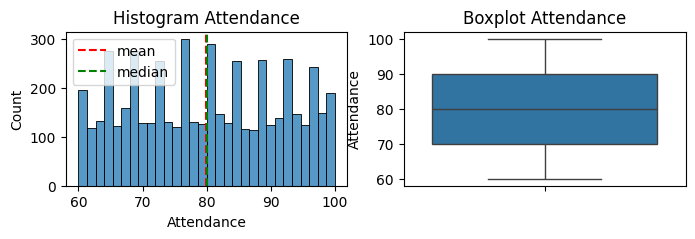

Skewness : 0.02500026898477935
Column |Attendance| normal distribution
✅ No outliers detected in 'Attendance'.


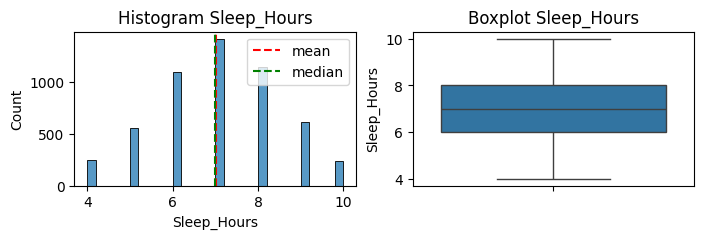

Skewness : -0.03430403918456252
Column |Sleep_Hours| normal distribution
✅ No outliers detected in 'Sleep_Hours'.


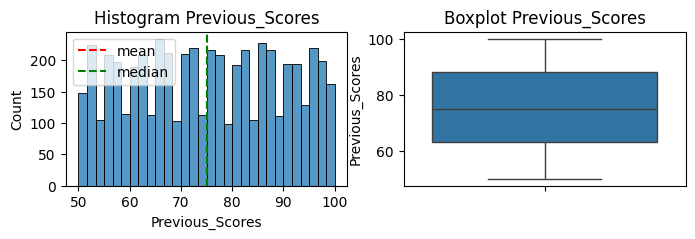

Skewness : -0.0011336632779839575
Column |Previous_Scores| normal distribution
✅ No outliers detected in 'Previous_Scores'.


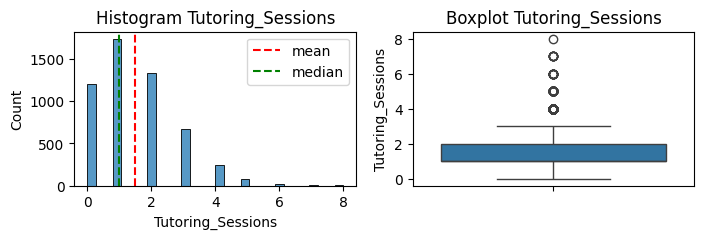

Skewness : 0.8270257443785801
Column |Tutoring_Sessions| right skewed
⚠️ Outliers detected in 'Tutoring_Sessions': [4, 4, 5, 5, 4]


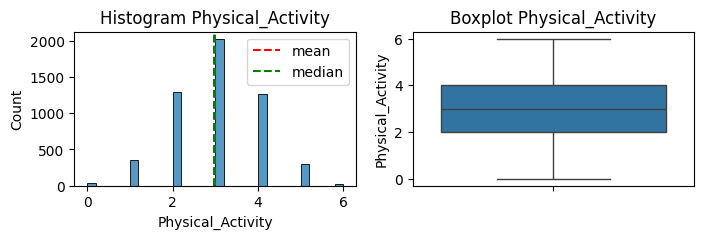

Skewness : -0.031782684688565085
Column |Physical_Activity| normal distribution
✅ No outliers detected in 'Physical_Activity'.


In [11]:
for col in num_cols:
    plot_dist(X_train, col)

# Data Preprocessing

In [12]:
X_train.isnull().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               60
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      69
Distance_from_Home            51
Gender                         0
dtype: int64

In [13]:
missing_num_cols = X_train[num_cols].isnull().sum()[X_train[num_cols].isnull().sum() > 0].index.to_list()
missing_object_cols = X_test[object_cols].isnull().sum()[X_test[object_cols].isnull().sum() > 0].index.to_list()

display(missing_num_cols, missing_object_cols)

[]

['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']

## Null Value Imputation

In [14]:
# Categorical --> Most Frequent
for col in missing_num_cols:
    median_value = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

for col in missing_object_cols:
    most_freq = X_train[col].value_counts().idxmax()
    X_train[col] = X_train[col].fillna(most_freq)
    X_test[col] = X_test[col].fillna(most_freq)

# Feature Engineering

In [15]:
X_train[object_cols].head()

,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Motivation_Level,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
5810,Low,High,Yes,High,Yes,Low,Medium,Public,Negative,No,College,Moderate,Female
1268,High,Medium,Yes,Medium,Yes,Low,High,Public,Neutral,No,High School,Moderate,Female
414,Low,Medium,No,Low,Yes,Low,Medium,Public,Neutral,No,College,Far,Male
4745,High,Medium,Yes,Medium,Yes,Medium,Medium,Public,Neutral,No,High School,Near,Male
654,High,Low,Yes,Medium,Yes,Low,Medium,Private,Positive,No,High School,Near,Male


## Column Tranformer

In [16]:
ordinal_mappings = [
    ['Low', 'Medium', 'High'],  # Teacher_Quality
    ['Low', 'Medium', 'High'],  # Parental_Involvement
    ['Low', 'Medium', 'High'],  # Access_to_Resources
    ['Low', 'Medium', 'High'],  # Motivation_Level
    ['Low', 'Medium', 'High'],  # Family_Income
    ['Negative', 'Neutral', 'Positive'],  # Peer_Influence
    ['High School', 'College', 'Postgraduate']  # Parental_Education_Level
]

ordinal_cols = ['Teacher_Quality', 'Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 
                'Family_Income', 'Peer_Influence', 'Parental_Education_Level']
ohe_cols = [i for i in object_cols if i not in ordinal_cols]
scaler_cols = no_outlier
robust_cols = outlier

transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), scaler_cols),
        ('robust', RobustScaler(), robust_cols),
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'), ohe_cols),
        ('ordinal', OrdinalEncoder(categories=ordinal_mappings), ordinal_cols)
    ])

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [17]:
ohe_feature_names = transformer.named_transformers_['ohe'].get_feature_names_out(ohe_cols)
all_feature_names = scaler_cols + robust_cols + list(ohe_feature_names) + ordinal_cols

X_train_df = pd.DataFrame(X_train, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test, columns=all_feature_names)

X_train_df.head()

,Attendance,Sleep_Hours,Previous_Scores,Physical_Activity,Hours_Studied,Tutoring_Sessions,Extracurricular_Activities_No,Extracurricular_Activities_Yes,Internet_Access_No,Internet_Access_Yes,...,Distance_from_Home_Near,Gender_Female,Gender_Male,Teacher_Quality,Parental_Involvement,Access_to_Resources,Motivation_Level,Family_Income,Peer_Influence,Parental_Education_Level
0,-0.075846,0.669094,-0.837277,1.964909,0.875,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0
1,0.531894,-0.016740,1.314728,0.030381,-0.500,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0
2,0.618714,0.669094,0.551113,-1.904146,0.250,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
3,1.747376,2.040764,0.759372,0.030381,-0.250,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
4,-0.162667,2.040764,1.661825,-0.936882,1.875,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,2.0,0.0


3)

# Model Testing

In [18]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Huber Regressor": HuberRegressor(),
    "Polynomial Regression (Degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "r2"

# Store model names and scores
model_names = []
mean_scores = []

# Evaluate models
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)
    mean_score = scores.mean()
    
    print(f"{name} Cross-Validation {scoring} Scores:\n {scores}")
    print(f"Mean {scoring}: {mean_score}\n")
    
    model_names.append(name)
    mean_scores.append(mean_score)

Linear Regression Cross-Validation r2 Scores:
 [0.70884862 0.72062844 0.77491292 0.66546736 0.71240001]
Mean r2: 0.7164514690755927

Ridge Regression Cross-Validation r2 Scores:
 [0.70882538 0.72046966 0.77491663 0.66545414 0.71227246]
Mean r2: 0.7163876565447784

Lasso Regression Cross-Validation r2 Scores:
 [0.6814708  0.69456181 0.74288444 0.64391883 0.67938352]
Mean r2: 0.6884438812417212

ElasticNet Cross-Validation r2 Scores:
 [0.691413   0.70172532 0.75414896 0.6532362  0.68984042]
Mean r2: 0.6980727802783295

Huber Regressor Cross-Validation r2 Scores:
 [0.70757696 0.71953051 0.77597141 0.66460417 0.71068485]
Mean r2: 0.7156735795039852

Polynomial Regression (Degree 2) Cross-Validation r2 Scores:
 [0.68839537 0.70085167 0.75426708 0.64107889 0.69842762]
Mean r2: 0.6966041267925711

SVR Cross-Validation r2 Scores:
 [0.69647698 0.71017437 0.76570253 0.65535136 0.6900014 ]
Mean r2: 0.7035413263694659

Random Forest Cross-Validation r2 Scores:
 [0.62099767 0.63987829 0.66550094 0.

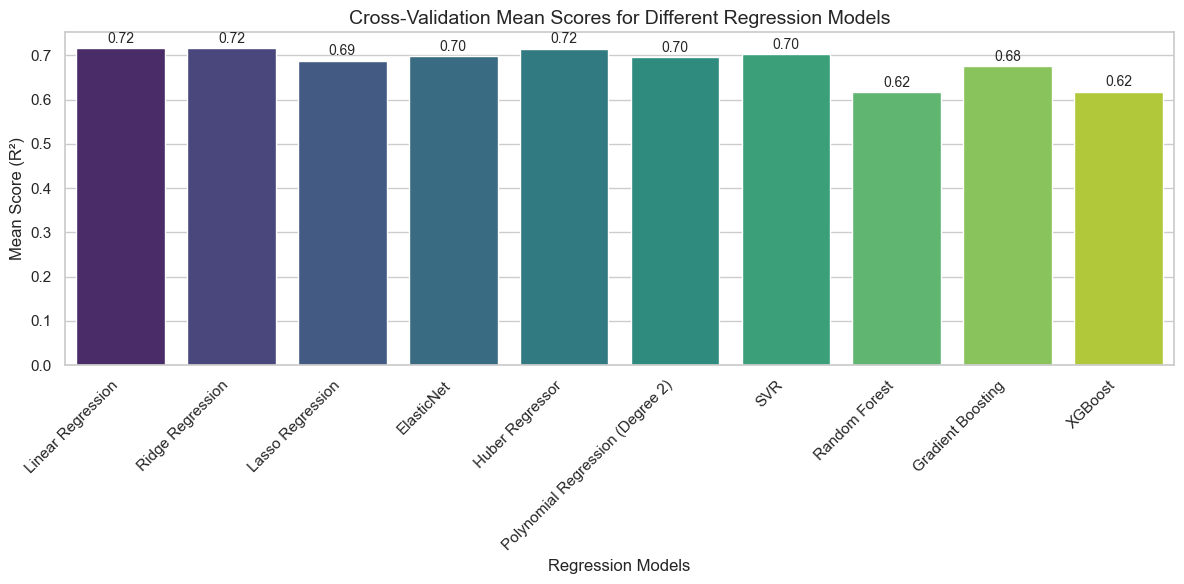

In [19]:
data = pd.DataFrame({'Model': model_names, 'Mean Score': mean_scores})

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Model', y='Mean Score', data=data, palette='viridis')

for i in range(len(mean_scores)):
    barplot.text(i, mean_scores[i] + 0.005, f"{mean_scores[i]:.2f}", ha='center', va='bottom', fontsize=10)

plt.title('Cross-Validation Mean Scores for Different Regression Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Regression Models', fontsize=12)
plt.ylabel('Mean Score (R²)', fontsize=12)
plt.tight_layout()
plt.show()

## Fine Tuning

In [20]:
ridge_model = Ridge()

ridge_params = {
    "alpha": [0.001, 0.01, 0.1, 1, 5, 10, 20, 100]
}

ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring="r2", n_jobs=-1)
ridge_grid.fit(X_train, y_train)

print(f"Best Ridge Parameters: {ridge_grid.best_params_}")
print(f"Best Ridge R² Score: {ridge_grid.best_score_:.4f}")

Best Ridge Parameters: {'alpha': 10}
Best Ridge R² Score: 0.7237


In [21]:
best_params = ridge_grid.best_params_

best_model_ridge = Ridge()
best_model_ridge.set_params(**best_params)

best_model_ridge.fit(X_train, y_train)

Ridge(alpha=10)

## Model Evaluation

In [22]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = best_model_ridge.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    return pd.DataFrame([R2_Score, MAE, RMSE, MAPE],
                        index=['R2-Score', 'MAE', 'RMSE', 'MAPE'],
                        columns=[model_name])

model_evaluation(best_model_ridge, X_test, y_test, 'Linear Regression')

,Linear Regression
R2-Score,0.770468
MAE,0.446673
RMSE,1.801236
MAPE,0.620161


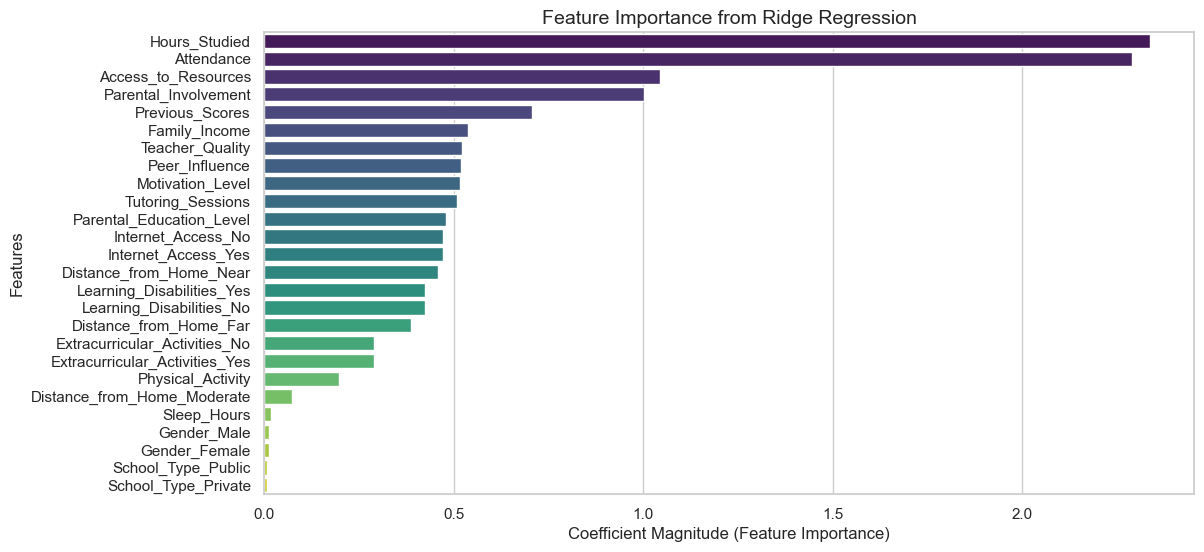

In [23]:
feature_importance = np.abs(ridge_grid.best_estimator_.coef_)
feature_names = X_train_df.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel("Coefficient Magnitude (Feature Importance)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance from Ridge Regression", fontsize=14)
plt.show()

## Model Visualization

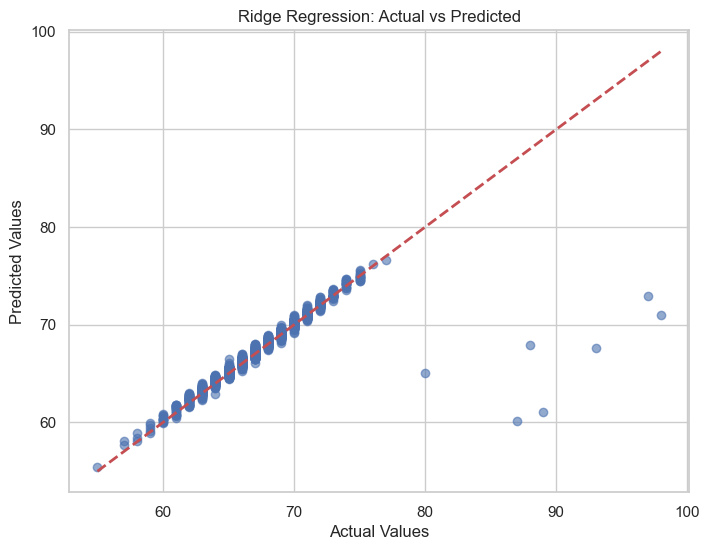

In [24]:
y_pred = best_model_ridge.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Ideal fit line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Actual vs Predicted")
plt.show()

# Model Saving

In [25]:
joblib.dump(best_model_ridge, "best_model.pkl")
joblib.dump(transformer, "transformer_data.pkl")
print("Model & Transformer saved successfully!")

Model & Transformer saved successfully!
